In [3]:
# Step 1: Import libraries and configure TensorFlow for GPU
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import tensorflow as tf
from tqdm import tqdm  # Progress bar library

# Enable GPU usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
# Paths
data_dir = "/kaggle/input/humpback-whale-identification"
train_images_dir = os.path.join(data_dir, "train")
test_images_dir = os.path.join(data_dir, "test")
train_csv_path = os.path.join(data_dir, "train.csv")
sample_submission_path = os.path.join(data_dir, "sample_submission.csv")

In [6]:
# Load the CSV file
train_csv_path = os.path.join(data_dir, "train.csv")
train_df = pd.read_csv(train_csv_path)
print("Data loaded successfully. Sample data:")
print(train_df.head())

# Handling imbalanced data: Combine rare classes into "new_whale"
min_samples_per_class = 2
whale_counts = train_df["Id"].value_counts()
rare_whales = whale_counts[whale_counts < min_samples_per_class].index
train_df["Id"] = train_df["Id"].apply(lambda x: "new_whale" if x in rare_whales else x)


Data loaded successfully. Sample data:
           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale


In [7]:
# Handling imbalanced data: Combine rare classes into "new_whale"
min_samples_per_class = 2
whale_counts = train_df["Id"].value_counts()
rare_whales = whale_counts[whale_counts < min_samples_per_class].index

# Update `Id` column to combine rare classes
train_df["Id"] = train_df["Id"].apply(lambda x: "new_whale" if x in rare_whales else x)

# Update the label encoder
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["Id"])

# Load and preprocess images with progress bar
train_images = []
train_labels = []

print("Loading and preprocessing training images...")
for _, row in tqdm(train_df.iterrows(), total=train_df.shape[0], desc="Processing images"):
    image_path = os.path.join(train_images_dir, row["Image"])
    img = preprocess_image(image_path, image_size)
    if img is not None:
        train_images.append(img)
        train_labels.append(row["label"])

train_images = np.array(train_images, dtype="float32")
train_labels = np.array(train_labels, dtype="int32")

# Train-test split (now safe for stratification)
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

print("Training and validation split completed.")

train_images = np.array(train_images, dtype="float32")
train_labels = np.array(train_labels, dtype="int32")

Loading and preprocessing training images...


Processing images:   0%|          | 0/25361 [00:00<?, ?it/s]


NameError: name 'preprocess_image' is not defined

In [8]:
# Step 1: Import libraries and configure TensorFlow for GPU
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import tensorflow as tf
from tqdm import tqdm  # Progress bar library

# Enable GPU and mixed precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Paths
data_dir = "/kaggle/input/humpback-whale-identification"
train_images_dir = os.path.join(data_dir, "train")
test_images_dir = os.path.join(data_dir, "test")
train_csv_path = os.path.join(data_dir, "train.csv")
sample_submission_path = os.path.join(data_dir, "sample_submission.csv")

# Load train.csv
train_df = pd.read_csv(train_csv_path)
print("Number of unique whale IDs:", train_df["Id"].nunique())

# Step 2: Data Preprocessing
# Encode labels
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["Id"])

# Handling imbalanced data
min_samples_per_class = 2
whale_counts = train_df["Id"].value_counts()
rare_whales = whale_counts[whale_counts < min_samples_per_class].index
train_df["Id"] = train_df["Id"].apply(lambda x: "new_whale" if x in rare_whales else x)

# Update the label encoder
train_df["label"] = le.fit_transform(train_df["Id"])

# Image preprocessing and resizing
image_size = (128, 128)

def preprocess_image(image_path, target_size):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(target_size)
    return np.array(img) / 255.0

# Load and preprocess images with progress bar
train_images = []
train_labels = []

print("Loading and preprocessing training images...")
for _, row in tqdm(train_df.iterrows(), total=train_df.shape[0], desc="Processing images"):
    image_path = os.path.join(train_images_dir, row["Image"])
    img = preprocess_image(image_path, image_size)
    train_images.append(img)
    train_labels.append(row["label"])

train_images = np.array(train_images, dtype="float32")
train_labels = np.array(train_labels, dtype="int32")

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Step 3: Model definition
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(*image_size, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(le.classes_), activation="softmax", dtype="float32")  # Ensure correct dtype for mixed precision
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

# Step 4: Model Training
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

# Step 5: Predictions with progress bar
test_images = []
test_image_names = []

print("Loading and preprocessing test images...")
for img_name in tqdm(os.listdir(test_images_dir), desc="Processing test images"):
    img_path = os.path.join(test_images_dir, img_name)
    img = preprocess_image(img_path, image_size)
    test_images.append(img)
    test_image_names.append(img_name)

test_images = np.array(test_images, dtype="float32")

print("Making predictions...")
predictions = []
for i in tqdm(range(0, len(test_images), 64), desc="Predicting"):
    batch_predictions = model.predict(test_images[i:i+64], batch_size=64)
    predictions.extend(batch_predictions)

predicted_labels = [le.inverse_transform([np.argmax(pred)])[0] for pred in predictions]

# Step 6: Submission
submission_df = pd.DataFrame({
    "Image": test_image_names,
    "Id": predicted_labels
})

submission_df.to_csv("submission.csv", index=False)


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Number of unique whale IDs: 5005
Loading and preprocessing training images...


Processing images: 100%|██████████| 25361/25361 [06:59<00:00, 60.41it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746789565.524296      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746789565.524918      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2932)                │       1,504,116 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,443,828 (55.10 MB)

 Trainable params: 14,443,380 (55.10 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50


I0000 00:00:1746789580.900607     104 service.cc:148] XLA service 0x7b94e8016640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746789580.901486     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746789580.901514     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746789581.437228     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-09 11:19:46.731347: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=0} for conv (f16[128,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,30,30,64]{3,2,1,0}, f16[64,28,28,128]{3,2,1,0}), window={size=3x3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"

  3/317 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.1727 - loss: 14.9463       

I0000 00:00:1746789593.178017     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


317/317 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.4048 - loss: 7.2576 - val_accuracy: 0.4628 - val_loss: 11.8219 - learning_rate: 0.0010
Epoch 2/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4423 - loss: 6.8251 - val_accuracy: 0.4626 - val_loss: 5.8869 - learning_rate: 0.0010
Epoch 3/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4571 - loss: 6.4911 - val_accuracy: 0.4628 - val_loss: 9.2227 - learning_rate: 0.0010
Epoch 4/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4642 - loss: 6.2348 - val_accuracy: 0.4628 - val_loss: 5.5352 - learning_rate: 0.0010
Epoch 5/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4677 - loss: 6.0065 - val_accuracy: 0.4628 - val_loss: 5.3531 - learning_rate: 0.0010
Epoch 6/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4590 - loss: 5.8042 - val_accuracy: 0.4628 - val_loss: 5.5462 - learning_rate: 0.0010
Epoch 7/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4614 - loss: 5.5901 - va

Processing test images: 100%|██████████| 7960/7960 [02:00<00:00, 65.82it/s]


Making predictions...


Predicting:   0%|          | 0/125 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


Predicting:   1%|          | 1/125 [00:00<01:18,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting:   2%|▏         | 3/125 [00:00<00:27,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:   4%|▍         | 5/125 [00:00<00:17,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:   6%|▌         | 7/125 [00:01<00:13,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:   7%|▋         | 9/125 [00:01<00:11, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:   9%|▉         | 11/125 [00:01<00:10, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting:  10%|█         | 13/125 [00:01<00:09, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  12%|█▏        | 15/125 [00:01<00:08, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  14%|█▎        | 17/125 [00:01<00:08, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  15%|█▌        | 19/125 [00:01<00:07, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  17%|█▋        | 21/125 [00:02<00:07, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  18%|█▊        | 23/125 [00:02<00:07, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  20%|██        | 25/125 [00:02<00:07, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  22%|██▏       | 27/125 [00:02<00:07, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting:  23%|██▎       | 29/125 [00:02<00:07, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  25%|██▍       | 31/125 [00:02<00:06, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  26%|██▋       | 33/125 [00:02<00:06, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting:  28%|██▊       | 35/125 [00:03<00:06, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting:  30%|██▉       | 37/125 [00:03<00:06, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting:  31%|███       | 39/125 [00:03<00:06, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  33%|███▎      | 41/125 [00:03<00:06, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  34%|███▍      | 43/125 [00:03<00:05, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting:  36%|███▌      | 45/125 [00:03<00:05, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting:  38%|███▊      | 47/125 [00:03<00:05, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  39%|███▉      | 49/125 [00:04<00:05, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting:  41%|████      | 51/125 [00:04<00:05, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  42%|████▏     | 53/125 [00:04<00:05, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  44%|████▍     | 55/125 [00:04<00:04, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  46%|████▌     | 57/125 [00:04<00:04, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  47%|████▋     | 59/125 [00:04<00:04, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  49%|████▉     | 61/125 [00:04<00:04, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  50%|█████     | 63/125 [00:05<00:04, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting:  52%|█████▏    | 65/125 [00:05<00:04, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  54%|█████▎    | 67/125 [00:05<00:04, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  55%|█████▌    | 69/125 [00:05<00:03, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  57%|█████▋    | 71/125 [00:05<00:03, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  58%|█████▊    | 73/125 [00:05<00:03, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  60%|██████    | 75/125 [00:05<00:03, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  62%|██████▏   | 77/125 [00:06<00:03, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  63%|██████▎   | 79/125 [00:06<00:03, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  65%|██████▍   | 81/125 [00:06<00:03, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting:  66%|██████▋   | 83/125 [00:06<00:03, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  68%|██████▊   | 85/125 [00:06<00:02, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  70%|██████▉   | 87/125 [00:06<00:02, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  71%|███████   | 89/125 [00:06<00:02, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  73%|███████▎  | 91/125 [00:07<00:02, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  74%|███████▍  | 93/125 [00:07<00:02, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  76%|███████▌  | 95/125 [00:07<00:02, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting:  78%|███████▊  | 97/125 [00:07<00:02, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  79%|███████▉  | 99/125 [00:07<00:01, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  81%|████████  | 101/125 [00:07<00:01, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  82%|████████▏ | 103/125 [00:07<00:01, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting:  84%|████████▍ | 105/125 [00:08<00:01, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  86%|████████▌ | 107/125 [00:08<00:01, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  87%|████████▋ | 109/125 [00:08<00:01, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  89%|████████▉ | 111/125 [00:08<00:01, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  90%|█████████ | 113/125 [00:08<00:00, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting:  92%|█████████▏| 115/125 [00:08<00:00, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  94%|█████████▎| 117/125 [00:08<00:00, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  95%|█████████▌| 119/125 [00:09<00:00, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting:  97%|█████████▋| 121/125 [00:09<00:00, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting:  98%|█████████▊| 123/125 [00:09<00:00, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Predicting: 100%|██████████| 125/125 [00:10<00:00, 11.76it/s]


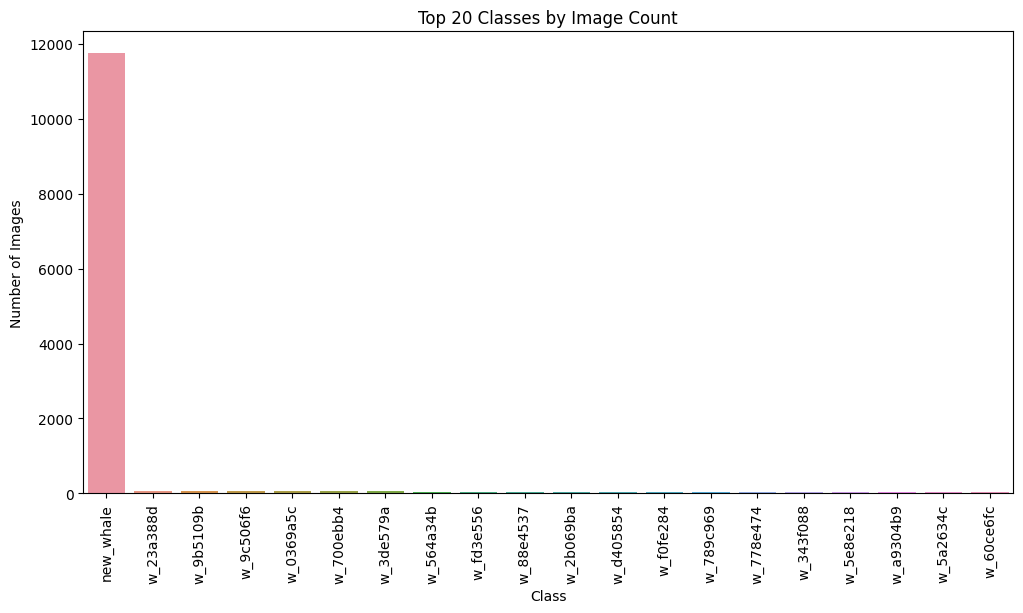

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


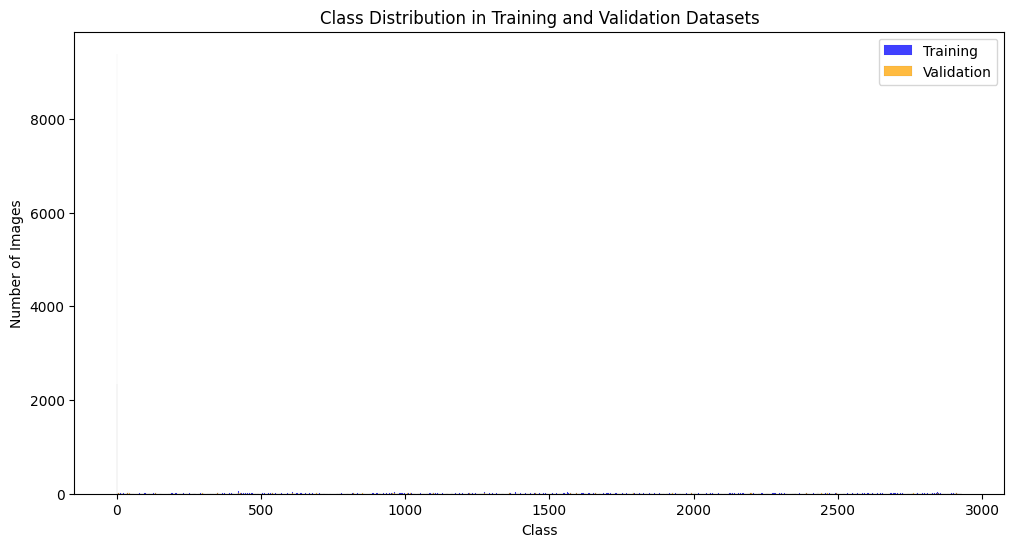

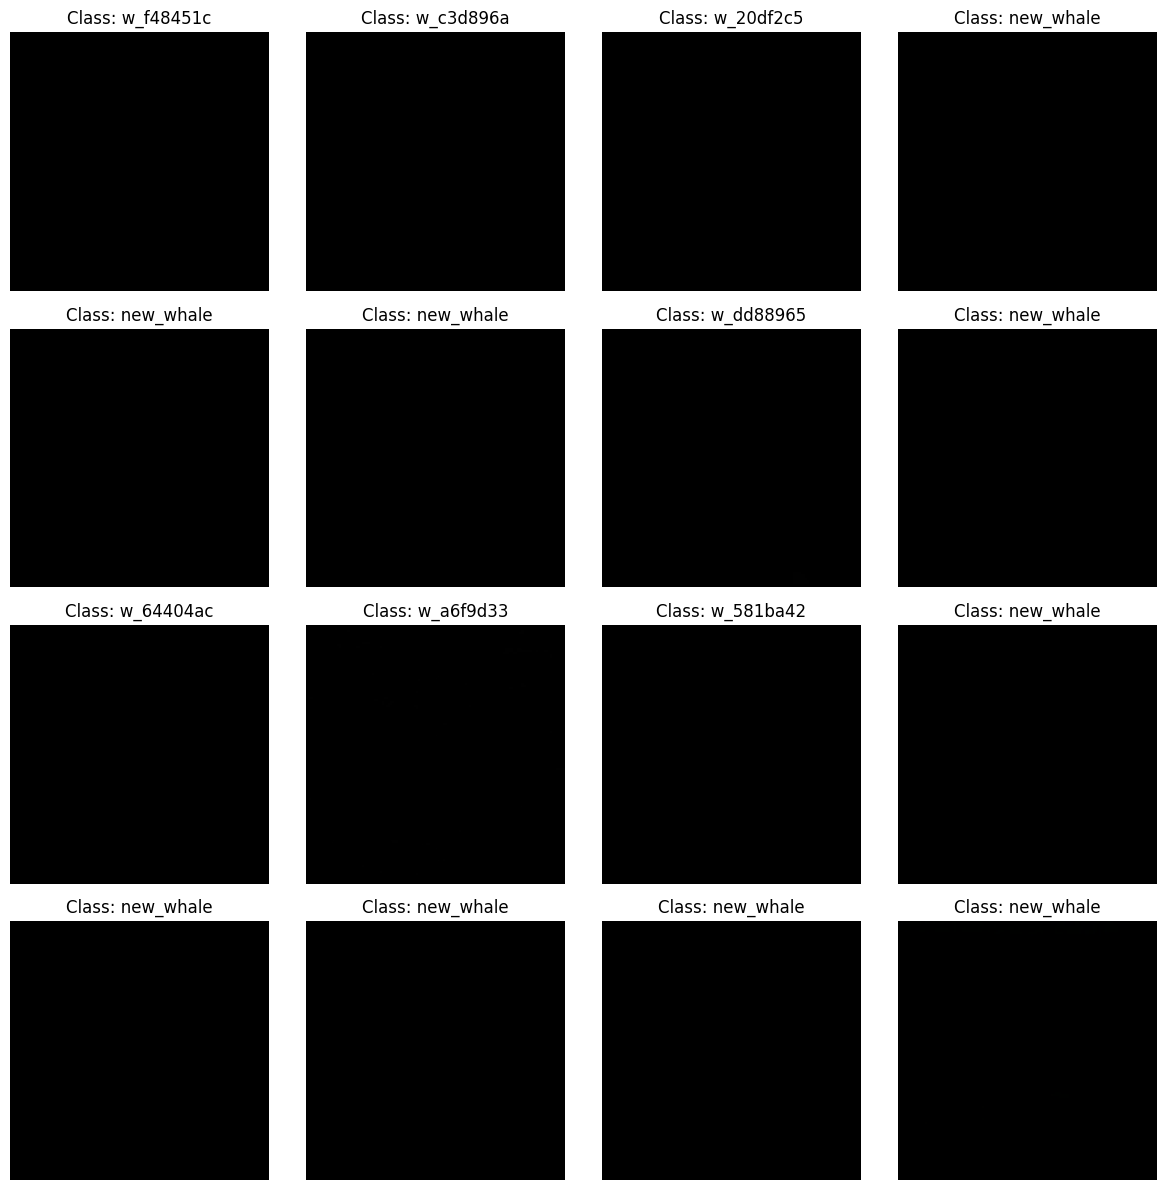

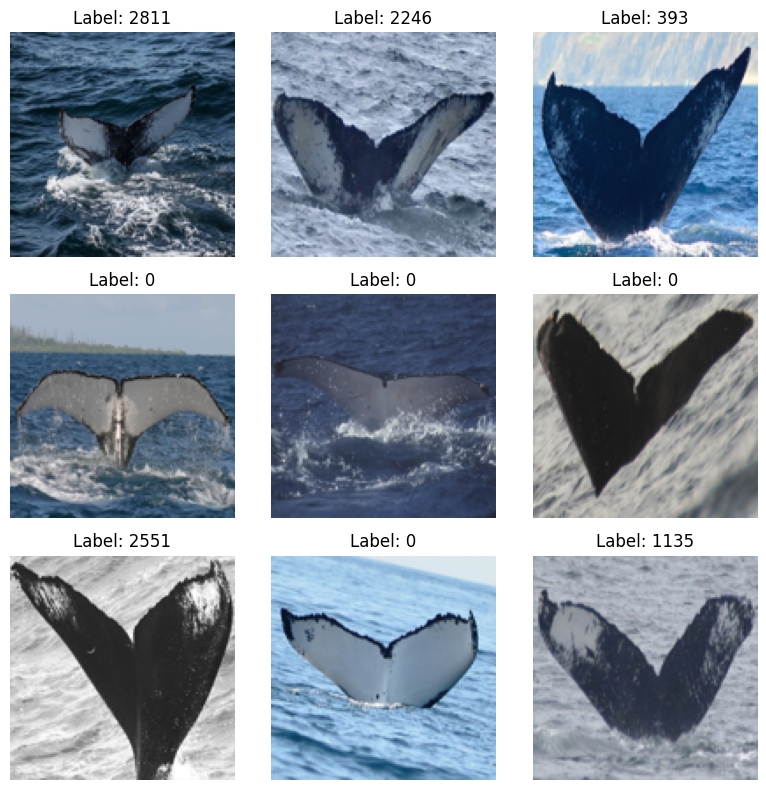

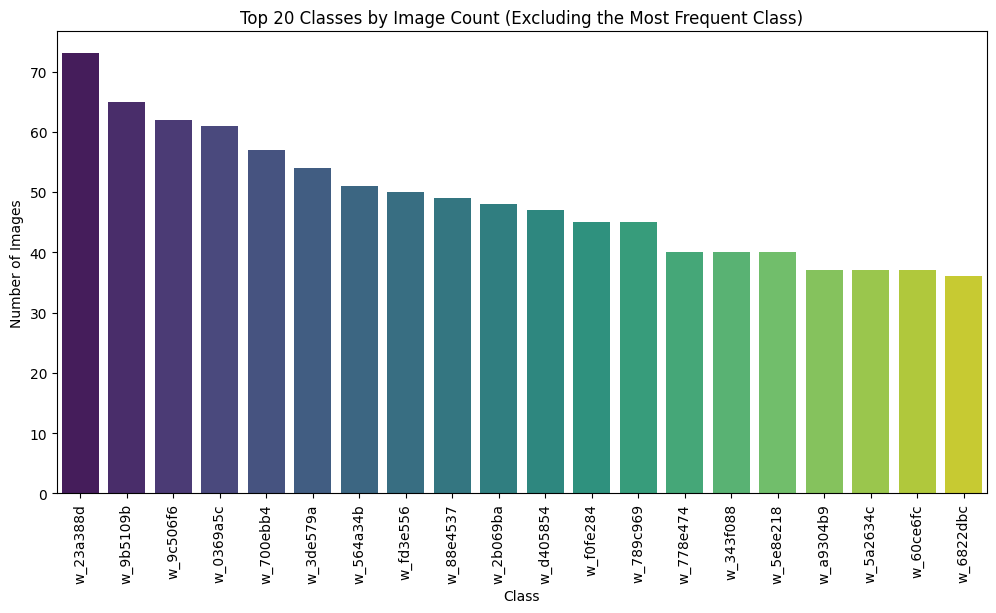

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Class Distribution Visualization
plt.figure(figsize=(12, 6))
class_counts = train_df["Id"].value_counts()
sns.barplot(x=class_counts.index[:20], y=class_counts.values[:20])
plt.xticks(rotation=90)
plt.title("Top 20 Classes by Image Count")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# 2. Training and Validation Dataset Distribution
plt.figure(figsize=(12, 6))
sns.histplot(y_train, bins=len(np.unique(y_train)), kde=False, color="blue", label="Training")
sns.histplot(y_val, bins=len(np.unique(y_val)), kde=False, color="orange", label="Validation")
plt.title("Class Distribution in Training and Validation Datasets")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.legend()
plt.show()

# 3. Sample Images from the Dataset
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i].astype("uint8"))
    plt.title(f"Class: {le.inverse_transform([train_labels[i]])[0]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# 4. Preprocessed Image Visualization
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].squeeze(), cmap="gray")
    plt.title(f"Label: {train_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Exclude the first class and focus on the next top 20 classes
plt.figure(figsize=(12, 6))

# Exclude the most frequent class and take the next 20
class_counts_excluded = class_counts.iloc[1:21]  # Start from index 1 to exclude the first class

sns.barplot(x=class_counts_excluded.index, y=class_counts_excluded.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 20 Classes by Image Count (Excluding the Most Frequent Class)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


In [11]:
# Step 1: Import libraries and configure TensorFlow for GPU
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder

In [12]:
# Enable mixed precision and confirm GPU use
tf.keras.mixed_precision.set_global_policy("mixed_float16")
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [13]:
# Paths
data_dir = "/kaggle/input/humpback-whale-identification"
train_images_dir = os.path.join(data_dir, "train")
test_images_dir = os.path.join(data_dir, "test")
train_csv_path = os.path.join(data_dir, "train.csv")

In [14]:
# Load train.csv
train_df = pd.read_csv(train_csv_path)
print("Number of unique whale IDs:", train_df["Id"].nunique())

Number of unique whale IDs: 5005


In [15]:
# Encode and filter labels
le = LabelEncoder()
min_samples_per_class = 2
whale_counts = train_df["Id"].value_counts()
rare_whales = whale_counts[whale_counts < min_samples_per_class].index
train_df["Id"] = train_df["Id"].apply(lambda x: "new_whale" if x in rare_whales else x)
train_df["label"] = le.fit_transform(train_df["Id"])

In [16]:
# Add file path
train_df["filepath"] = train_df["Image"].apply(lambda x: os.path.join(train_images_dir, x))

In [17]:
# Image parameters
image_size = (224, 224)
batch_size = 32

In [18]:
# ImageDataGenerators for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="Id",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="sparse",
    subset="training",
    shuffle=True,
    seed=42
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="Id",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="sparse",
    subset="validation",
    shuffle=False,
    seed=42
)

Found 20289 validated image filenames belonging to 2932 classes.
Found 5072 validated image filenames belonging to 2932 classes.


In [20]:
# Step 2: Model definition using EfficientNet
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(len(le.classes_), activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ cast_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce    

 Total params: 6,209,559 (23.69 MB)

 Trainable params: 2,159,988 (8.24 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
# Step 3: Training
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


635/635 ━━━━━━━━━━━━━━━━━━━━ 286s 399ms/step - accuracy: 0.4538 - loss: 5.6025 - val_accuracy: 0.4761 - val_loss: 4.9836 - learning_rate: 0.0010
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 145s 226ms/step - accuracy: 0.4591 - loss: 5.0776 - val_accuracy: 0.4761 - val_loss: 4.9782 - learning_rate: 0.0010
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 137s 214ms/step - accuracy: 0.4644 - loss: 5.0075 - val_accuracy: 0.4761 - val_loss: 4.9972 - learning_rate: 0.0010
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 136s 213ms/step - accuracy: 0.4604 - loss: 5.0471 - val_accuracy: 0.4761 - val_loss: 5.0009 - learning_rate: 0.0010
Epoch 5/10
634/635 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4580 - loss: 5.0563
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
635/635 ━━━━━━━━━━━━━━━━━━━━ 137s 213ms/step - accuracy: 0.4581 - loss: 5.0563 - val_accuracy: 0.4761 - val_loss: 5.0595 - learning_rate: 0.0010
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 136s 213ms/step - accuracy: 0.4560 - 

In [23]:
# Step 4: Fine-tuning
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
104/635 ━━━━━━━━━━━━━━━━━━━━ 1:42 193ms/step - accuracy: 0.4675 - loss: 5.0660

RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL InternalError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/errors_impl.py(462): __init__
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/context.py(1683): call_function
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1322): _call_flat
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py(139): call_function
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(878): _call
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(833): __call__
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py(320): fit
  /usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py(117): error_handler
  /tmp/ipykernel_31/44234165.py(5): <cell line: 0>
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3553): run_code
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3473): run_ast_nodes
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3257): run_cell_async
  /usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3030): _run_cell
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(2975): run_cell
  /usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py(528): run_cell
  /usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py(383): do_execute
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(730): execute_request
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(499): process_one
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /usr/lib/python3.11/asyncio/events.py(84): _run
  /usr/lib/python3.11/asyncio/base_events.py(1936): _run_once
  /usr/lib/python3.11/asyncio/base_events.py(608): run_forever
  /usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py(205): start
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py(712): start
  /usr/local/lib/python3.11/dist-packages/traitlets/config/application.py(992): launch_instance
  /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py(37): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


In [24]:
# Step 5: Test Predictions
test_filenames = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png'))]
test_df = pd.DataFrame({"Image": test_filenames})
test_df["filepath"] = test_df["Image"].apply(lambda x: os.path.join(test_images_dir, x))

In [25]:
# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col=None,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

preds = model.predict(test_gen, verbose=1)
predicted_labels = [le.inverse_transform([np.argmax(p)])[0] for p in preds]

test_df["Id"] = predicted_labels
test_df[["Image", "Id"]].to_csv("submission1.csv", index=False)

Found 7960 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 99s 367ms/step


In [1]:
# Step 6: Plot training history
def plot_training_history(history1, history2=None):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Train (Initial)')
    plt.plot(history1.history['val_accuracy'], label='Val (Initial)')
    if history2:
        offset = len(history1.history['accuracy'])
        plt.plot(range(offset, offset + len(history2.history['accuracy'])), history2.history['accuracy'], label='Train (Fine-tune)')
        plt.plot(range(offset, offset + len(history2.history['val_accuracy'])), history2.history['val_accuracy'], label='Val (Fine-tune)')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Train (Initial)')
    plt.plot(history1.history['val_loss'], label='Val (Initial)')
    if history2:
        offset = len(history1.history['loss'])
        plt.plot(range(offset, offset + len(history2.history['loss'])), history2.history['loss'], label='Train (Fine-tune)')
        plt.plot(range(offset, offset + len(history2.history['val_loss'])), history2.history['val_loss'], label='Val (Fine-tune)')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history, history_finetune)


NameError: name 'history' is not defined